In [1]:
%cd ../..

/home/bhkuser/bhklab/katy/recist-vs-reality


In [2]:
from damply import dirs
import numpy as np
import pandas as pd
from scipy import stats
import logging
from pathlib import Path
import pydicom

logger = logging.getLogger(__name__)
logging.basicConfig(filename=dirs.LOGS / "match_ann_to_seg.log", encoding='utf-8', level=logging.DEBUG)

In [11]:
def get_ann_measurements(ann_dicom_file_path: Path): 
    '''
    Scrapes the raw annotation DICOM file for information relating to long axis measurements. Logs all possible measurements. 
    Assumes all relevant data in the SR follows the same structure and depth and that all measurements correspond to relevant tumours.

    Paramters
    ---------
    ann_dicom_file_path: Path
        Path to SR file

    Returns 
    ---------
    tum_info_df: pd.DataFrame
        Contains information related to file and the long and short axis measurements
    '''
    cols = ["PatientID",
            "AnnSeriesInstanceUID", 
            "LongAxisMeasureType", 
            "LongAxisUnit", 
            "LongAxisMeasurement", 
            "LongAxisRefSOPUID", 
            "ShortAxisMeasureType", 
            "ShortAxisUnit", 
            "ShortAxisMeasurement", 
            "ShortAxisRefSOPUID"]
    
    tum_info_df = pd.DataFrame(columns = cols)
    dicom_data = pydicom.dcmread(ann_dicom_file_path)

    patID = dicom_data.PatientID
    ann_seriesInstUID = dicom_data.SeriesInstanceUID
    parent_cont_seq = dicom_data.ContentSequence
    
    logger.info("Measurements being obtained for file: %s", ann_dicom_file_path)

    for cont_seq in range(len(parent_cont_seq[4]["ContentSequence"].value)): 
        measure_type_long = parent_cont_seq[4]["ContentSequence"][cont_seq]["ContentSequence"][2]["ConceptNameCodeSequence"][0]["CodeMeaning"].value
        measure_unit_long = parent_cont_seq[4]["ContentSequence"][cont_seq]["ContentSequence"][2]["MeasuredValueSequence"][0]["MeasurementUnitsCodeSequence"][0]["CodeValue"].value
        measurement_long = parent_cont_seq[4]["ContentSequence"][cont_seq]["ContentSequence"][2]["MeasuredValueSequence"][0]["NumericValue"].value
        ref_SOPUID_long = parent_cont_seq[4]["ContentSequence"][cont_seq]["ContentSequence"][2]["ContentSequence"][0]["ContentSequence"][0]["ReferencedSOPSequence"][0]["ReferencedSOPInstanceUID"].value

        logger.info("Long axis measurement of type %s and units %s has been obtained.", measure_type_long, measure_unit_long)
        logger.info("Long axis easurement value: %s", measurement_long)
        logger.info("Long axis corresponding ReferencedSOPUID: %s", ref_SOPUID_long)

        measure_type_short = parent_cont_seq[4]["ContentSequence"][cont_seq]["ContentSequence"][3]["ConceptNameCodeSequence"][0]["CodeMeaning"].value
        measure_unit_short = parent_cont_seq[4]["ContentSequence"][cont_seq]["ContentSequence"][3]["MeasuredValueSequence"][0]["MeasurementUnitsCodeSequence"][0]["CodeValue"].value
        measurement_short = parent_cont_seq[4]["ContentSequence"][cont_seq]["ContentSequence"][3]["MeasuredValueSequence"][0]["NumericValue"].value
        ref_SOPUID_short = parent_cont_seq[4]["ContentSequence"][cont_seq]["ContentSequence"][3]["ContentSequence"][0]["ContentSequence"][0]["ReferencedSOPSequence"][0]["ReferencedSOPInstanceUID"].value

        logger.info("Short axis measurement of type %s and units %s has been obtained.", measure_type_short, measure_unit_short)
        logger.info("Short axis measurement value: %s", measurement_short)
        logger.info("Short axis corresponding ReferencedSOPUID: %s", ref_SOPUID_short)

        #Check to make sure long and short axis measurements were taken on same slice. 
        if ref_SOPUID_long != ref_SOPUID_short: 
            logger.debug("Long and short axis measurements for SeriesInstanceUID %s not taken on the same slice")
            logger.debug("Long axis RefSOPUID: %s", ref_SOPUID_long)
            logger.debug("Short axis RefSOPUID: %s", ref_SOPUID_short)

        curr_tum_info = [patID,
                         ann_seriesInstUID, 
                         measure_type_long, 
                         measure_unit_long,
                         measurement_long, 
                         ref_SOPUID_long, 
                         measure_type_short,
                         measure_unit_short,
                         measurement_short, 
                         ref_SOPUID_short]
        
        curr_tum_df = pd.DataFrame([curr_tum_info], columns = cols)
        
        if tum_info_df.empty: 
            tum_info_df = curr_tum_df
        else:
            tum_info_df = pd.concat([tum_info_df, curr_tum_df])

    return tum_info_df

In [12]:
datasource = "TCIA_"
dataset = "NSCLC-Radiogenomics"

index_file = dirs.RAWDATA / (datasource + dataset) / ".imgtools"/ "images" / f"index.csv"
index_df = pd.read_csv(index_file)

diameter_directory = dirs.PROCDATA / (datasource + dataset )/ "features" / "rvr_measurements" / "pyradiomics_measurement_subset_axislen.csv"
diameter_df = pd.read_csv(diameter_directory)

In [22]:
sr_filepaths = list(Path(dirs.RAWDATA / "TCIA_NSCLC-Radiogenomics/images/annotations/NSCLC-Radiogenomics").glob("*.dcm"))

sr_file_data = []
for sr_filepath in sr_filepaths:
    sr_file_data.append(get_ann_measurements(sr_filepath))

sr_data = pd.concat(sr_file_data, ignore_index=True).sort_values(by=["PatientID", "AnnSeriesInstanceUID"])

In [23]:
sr_data

,PatientID,AnnSeriesInstanceUID,LongAxisMeasureType,LongAxisUnit,LongAxisMeasurement,LongAxisRefSOPUID,ShortAxisMeasureType,ShortAxisUnit,ShortAxisMeasurement,ShortAxisRefSOPUID
161,AMC-001,2.25.557412904088002634779097194346544258273,Long Axis,mm,16.1,1.3.6.1.4.1.14519.5.2.1.4334.1501.204038471157...,Short Axis,mm,8.1,1.3.6.1.4.1.14519.5.2.1.4334.1501.204038471157...
113,AMC-001,2.25.656273650814296327982116545324746541860,Long Axis,mm,21.1,1.3.6.1.4.1.14519.5.2.1.4334.1501.231208660295...,Short Axis,mm,10.6,1.3.6.1.4.1.14519.5.2.1.4334.1501.231208660295...
114,AMC-001,2.25.656273650814296327982116545324746541860,Long Axis,mm,21.8,1.3.6.1.4.1.14519.5.2.1.4334.1501.193651866486...,Short Axis,mm,19.1,1.3.6.1.4.1.14519.5.2.1.4334.1501.193651866486...
115,AMC-001,2.25.656273650814296327982116545324746541860,Long Axis,mm,10.3,1.3.6.1.4.1.14519.5.2.1.4334.1501.269538794972...,Short Axis,mm,7.4,1.3.6.1.4.1.14519.5.2.1.4334.1501.269538794972...
116,AMC-001,2.25.656273650814296327982116545324746541860,Long Axis,mm,68.0,1.3.6.1.4.1.14519.5.2.1.4334.1501.698333416459...,Short Axis,mm,66.5,1.3.6.1.4.1.14519.5.2.1.4334.1501.698333416459...
...,...,...,...,...,...,...,...,...,...,...
47,R01-139,2.25.868499889926261817569210695690073583866,Long Axis,mm,35.4,1.3.6.1.4.1.14519.5.2.1.4334.1501.899684217763...,Short Axis,mm,27.8,1.3.6.1.4.1.14519.5.2.1.4334.1501.899684217763...
48,R01-139,2.25.868499889926261817569210695690073583866,Long Axis,mm,25.2,1.3.6.1.4.1.14519.5.2.1.4334.1501.867071236256...,Short Axis,mm,14.9,1.3.6.1.4.1.14519.5.2.1.4334.1501.867071236256...
104,R01-142,2.25.121679603710426133108964793076652636389,Long Axis,mm,29.6,1.3.6.1.4.1.14519.5.2.1.4334.1501.338348996622...,Short Axis,mm,19.7,1.3.6.1.4.1.14519.5.2.1.4334.1501.338348996622...
68,R01-145,2.25.714523259402514268351463827464804029099,Long Axis,mm,28.5,1.3.6.1.4.1.14519.5.2.1.4334.1501.191062990209...,Short Axis,mm,21.1,1.3.6.1.4.1.14519.5.2.1.4334.1501.191062990209...


Text(0.5, 0, 'Patient ID')

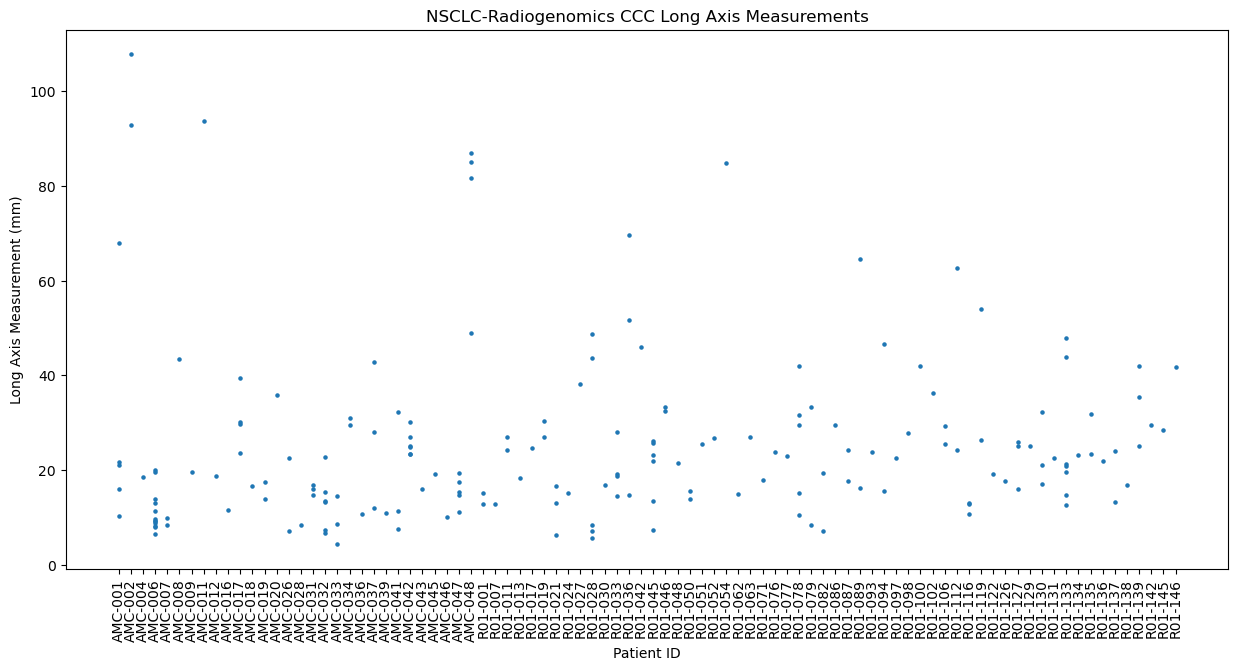

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
plt.scatter(sr_data["PatientID"], sr_data["LongAxisMeasurement"], s=5)
plt.xticks(rotation=90, fontsize = 10)
plt.title(f"{dataset} CCC Long Axis Measurements")
plt.ylabel("Long Axis Measurement (mm)")
plt.xlabel("Patient ID")



In [ ]:
largest_sr_data =sr_data.groupby("PatientID")['LongAxisMeasurement'].max()

In [ ]:
diameter_data = diameter_df['original_shape_MajorAxisLength']
diameter_data.index = diameter_df['SampleID'].str.replace(r"_[0-9][0-9][0-9][0-9]", "", regex=True)

SampleID
R01-001    18.625262
R01-002    18.769907
R01-004    21.634800
R01-005    27.326629
R01-006    24.049016
             ...    
R01-141    34.874948
R01-142    44.292919
R01-144    28.029185
R01-145    37.543949
R01-146    68.881505
Name: original_shape_MajorAxisLength, Length: 143, dtype: float64

In [63]:
measurements_df = pd.merge(largest_sr_data, diameter_data, left_index=True, right_index=True)

stats.ttest_ind(measurements_df['LongAxisMeasurement'], measurements_df['original_shape_MajorAxisLength'])

TtestResult(statistic=np.float64(-2.6521770719968525), pvalue=np.float64(0.009137016780835084), df=np.float64(114.0))

Text(0.5, 1.0, 'NSCLC-Radiogenomics (n=58)')

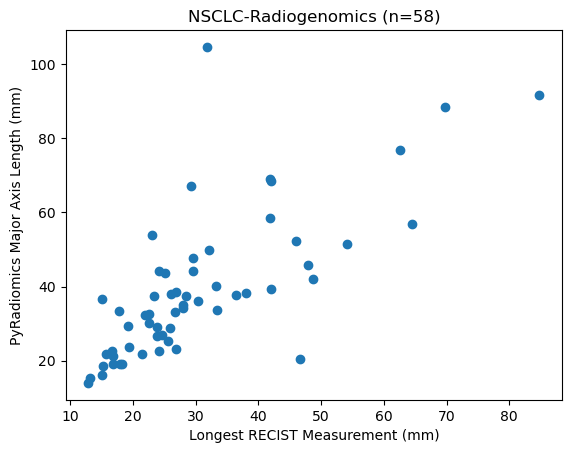

In [68]:
plt.scatter(measurements_df['LongAxisMeasurement'], measurements_df['original_shape_MajorAxisLength'])
plt.xlabel("Longest RECIST Measurement (mm)")
plt.ylabel("PyRadiomics Major Axis Length (mm)")
plt.title("NSCLC-Radiogenomics (n=58)")

In [64]:
measurements_df

,LongAxisMeasurement,original_shape_MajorAxisLength
R01-001,15.2,18.625262
R01-007,12.9,14.032836
R01-011,26.9,38.400693
R01-013,18.3,19.217911
R01-017,24.7,27.054651
R01-019,30.3,36.089010
R01-021,16.6,22.677128
R01-024,15.1,36.552854
R01-027,38.1,38.290220
R01-028,48.7,41.916533
